In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/unimodal/orig_0_1_2_cnmp/1717370718/'

data_path = root_path + test_path + 'y.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')

num_modes = 1
num_demos = Y.shape[0]
num_indiv = Y.shape[0]//num_modes
t_steps = Y.shape[1]

y_min, y_max = np.min(Y), np.max(Y)

Y_means = np.zeros((num_modes,Y.shape[1]))
for i in range(num_modes):
    Y_means[i] = np.mean(Y[i*num_indiv:(i+1)*num_indiv], axis=0)

x: (100,), Y: (24, 100)


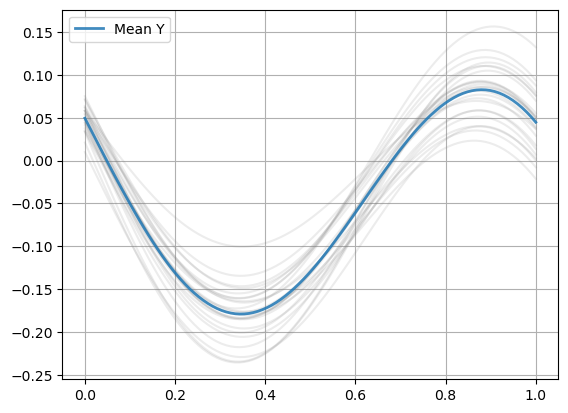

In [3]:
# plot Y and Y_means
plt.plot(x, Y.T, color='gray', alpha=0.15)
plt.plot(x, Y_means.T, label='Mean Y', alpha=0.85, linewidth=2)
plt.legend()
plt.grid()
plt.show()

In [4]:
def find_closest_traj_ind(traj, cut=0):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    traj = traj[:-cut] if cut != 0 else traj
    traj_length = traj.shape[0]
    for i, y in enumerate(Y):
        if cut != 0:
            dist = compute_euclidean_dist(y[-traj_length-cut:-cut], traj)  # euclidean distance between two trajectories
        else:
            dist = compute_euclidean_dist(y, traj)
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind, min_dist


def compute_euclidean_dist(traj0, traj1):
    traj_length = traj0.shape[np.argmax(traj0.shape)]
    assert traj_length > 10, f"Trajectory length is too short: {traj_length}"
    
    traj0 = traj0.reshape(traj_length)
    traj1 = traj1.reshape(traj_length)

    dist = np.sum(np.sqrt((traj0 - traj1) ** 2))
    coeff = t_steps/traj_length
    return dist * coeff

In [5]:
model_folder = 'saved_models/'
models_path = f'{root_path}{test_path}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 6, 6
t_steps = 100
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [128,128], decoder_hidden_dims=[128,128], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)

In [6]:
from tqdm import tqdm

num_demos = Y.shape[0]
num_tests = 30

# y0 = np.mean(Y[:, 0])
# y1_min, y1_max = np.min(Y[:, -1]), np.max(Y[:, -1])

y0_min, y0_max = np.min(Y[:, 0]), np.max(Y[:, 0])

import seaborn as sns

# from matplotlib.lines import Line2D

# dark_gray = '#4d4d4d'

# colors = [sns.color_palette('tab10')[8], sns.color_palette('tab10')[3], 
#           sns.color_palette('tab10')[0], sns.color_palette('tab10')[4], 
#           sns.color_palette('tab10')[1]]

# # linestyles = [(5, (7, 2)), (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]
# linestyles = [(0, (3, 1, 1, 1, 1, 1)), '--', ':', '-.', '-']

y1_min, y1_max = np.min(Y[:, -1]), np.max(Y[:, -1])

y0s = np.linspace(y0_min, y0_max, num_tests)
y1s = np.linspace(y1_min, y1_max, num_tests)

num_models = 9
# 0: DMP, 1: ProMP, 2: GMR, 3: CNMP, 4:CNEP, 5: CNEP-MoE, 6: CNEP-A0, 7: CNEP-A1, 8: CNEP-A2

euc_errors = np.zeros((num_tests*num_tests, num_models))
# plt.plot(x, Y.T, color='gray', alpha=0.15)

for i0 in tqdm(range(num_tests)):
    y0 = y0s[i0]
    for i1 in range(num_tests):
        y1 = y1s[i1]
        d = DMP(n_dims=1, n_weights_per_dim=20, dt=(1/99))

        for traj in Y:
            d.imitate(x, traj.reshape(-1,1))

        p = ProMP(n_dims=1, n_weights_per_dim=20)
        p.imitate(np.tile(x, (num_demos, 1)), Y)

        input_data = x.reshape(-1, 1)  # Phase variable as a column vector

        priors = 20  # Number of GMM components
        gmr_model = GMM(n_components=priors, random_state=1234)
        gmr_model.from_samples(Y)

        # DMP
        d.configure(start_y=[y0], goal_y=[y1])
        t, trajectory = d.open_loop()

        # ProMP
        p = p.condition_position(y0, t=0).condition_position(y1, t=1)
        trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

        # GMR
        gmr_model_ = gmr_model.condition([0, -1], [y0, y1])
        trajectory_g = gmr_model_.sample(1)
        trajectory_g = np.insert(trajectory_g, 0, y0)
        trajectory_g = np.append(trajectory_g, y1)

        # CNMP and CNEP
        val_obs[0, :2, :dx] = torch.tensor([0, 1]).unsqueeze(1)
        val_obs[0, :2, dx:] = torch.tensor([y0, y1]).unsqueeze(1)

        with torch.no_grad():
            trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
            pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
            dec_id = torch.argmax(gate.squeeze(1), dim=-1)
            trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

            confs = gate.view(1, 1, 1, 1)
            preds = pred_cnep[:, :, :, :dy]

            weighted_preds = preds * confs  # Element-wise multiplication, shape (4, 1, 200, 1)
            trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)

            pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
            dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
            trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

            pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
            dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
            trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

            pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
            dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
            trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]

        # plt.plot(x, trajectory_cnep, color='blue', alpha=0.5)
        # plt.plot(x, trajectory_p[0], color='red', alpha=0.5)

        for j in range(num_models):
            if j == 0:
                traj = trajectory
            elif j == 1:
                traj = trajectory_p.squeeze(0)
            elif j == 2:
                traj = trajectory_g
            elif j == 3:
                traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
            elif j == 4:
                traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()
            elif j == 5:
                traj = trajectory_cnep_moe.squeeze(0).squeeze(0).squeeze(-1).numpy()
            elif j == 6:
                traj = trajectory_cnep0.squeeze(0).squeeze(-1).numpy()
            elif j == 7:
                traj = trajectory_cnep1.squeeze(0).squeeze(-1).numpy()
            elif j == 8:
                traj = trajectory_cnep2.squeeze(0).squeeze(-1).numpy()

            cut = 0
            # if j == 3:
            #     cut = 2

            closest_traj_ind, closest_dist = find_closest_traj_ind(traj, cut)
            euc_errors[i0*num_tests+i1, j] = closest_dist / t_steps

    # plt.plot(x, Y_means.T, color='red', label='Mean Y', alpha=0.85, linewidth=2)
# plt.legend()
# plt.grid()
# plt.show()
        # cut = 0
        # if j == 4:
        #     cut = 3

        # rmse_errors[i, j] = compute_rmse(traj, Y_means[0], cut)
        # mae_errors[i, j] = compute_mae(traj, Y_means[0], cut)
        # max_errors[i, j] = compute_max_error(traj, Y_means[0], cut)

100%|██████████| 30/30 [15:03<00:00, 30.12s/it]


In [7]:
# print mean errors and standard deviations
y_min, y_max = np.min(Y), np.max(Y)
euc_errors /= (y_max-y_min)  # scaling
print('Euc error')
print(np.mean(euc_errors, axis=0))
print(np.std(euc_errors, axis=0))

Euc error
[0.04608929 0.02325127 0.02199803 0.02085832 0.02097806 0.02097806
 0.02269897 0.02067799 0.02487376]
[0.03469567 0.01271716 0.01217224 0.01095503 0.00946751 0.00946751
 0.01075202 0.01011978 0.01256882]


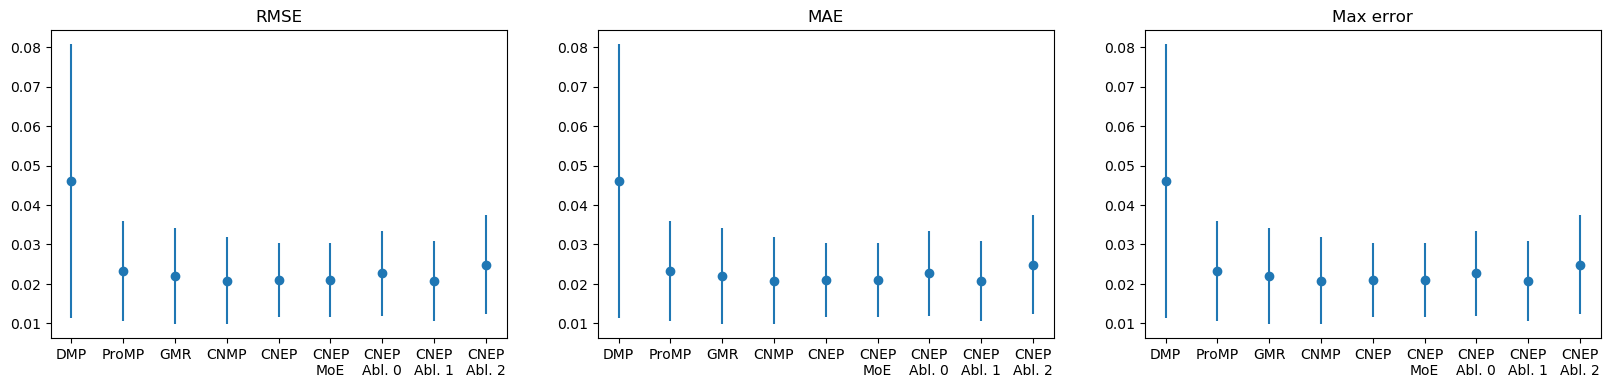

In [8]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
ax[0].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[0].set_title('RMSE')
ax[1].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()

# fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# # x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
# x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP']
# ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
# ax[0].set_title('RMSE')
# ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
# ax[1].set_title('MAE')
# ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
# ax[2].set_title('Max error')
# plt.show()

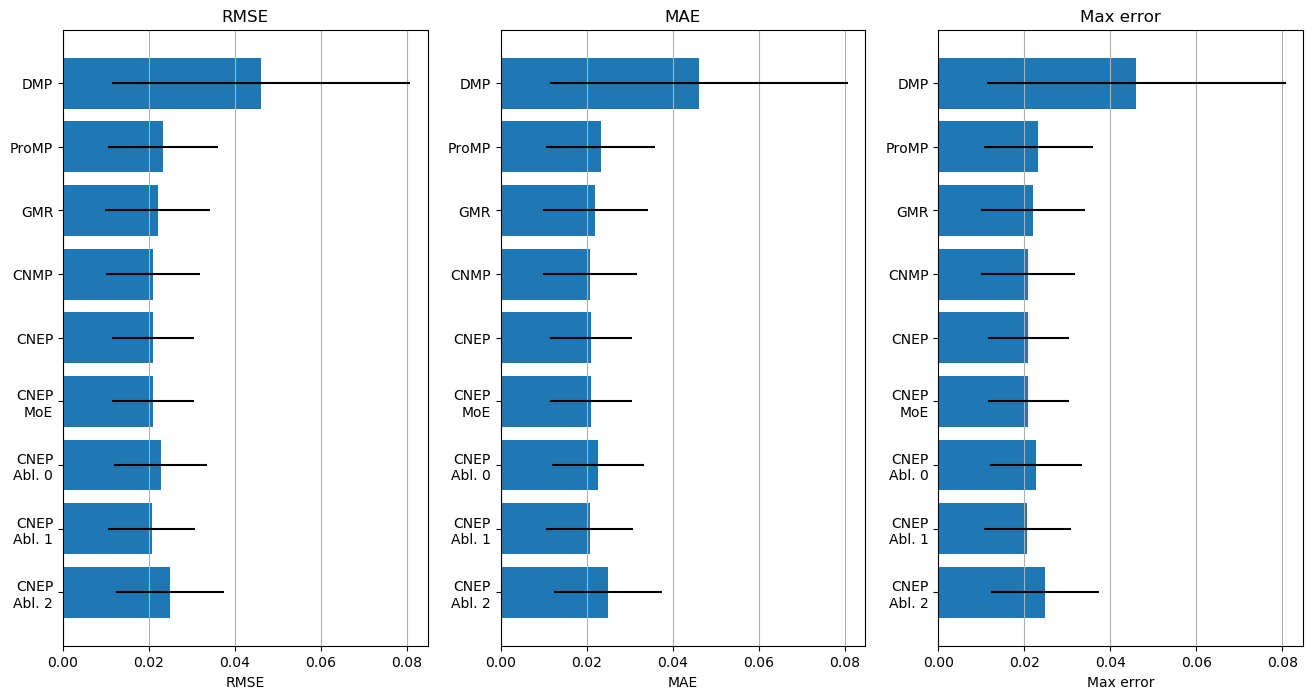

In [9]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('RMSE')
ax[0].set_title('RMSE')
ax[1].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()